In [1]:
import numpy as np
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os, string
import pandas as pd

from ast import literal_eval

from process_predictions import get_predictions
from utils import assess_performance, flatten, compare_preds

import fasttext

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = os.path.join(
    "..",
    "..",
    "..",
    "..",
    "data",
    "frameworks_data",
    "development_cca",
    "test_data.csv",
)

test_df = pd.read_csv(DATA_PATH)
test_df["target"] = test_df["target"].apply(literal_eval)

test_df["sectors"] = test_df["sectors"].apply(
    lambda x: [item.split("->")[-1] for item in literal_eval(x)]
)
test_df["subpillars"] = test_df["subpillars"].apply(
    lambda x: ["->".join(item.split("->")[1:]) for item in literal_eval(x)]
)

test_df.head(2)


,entry_id,excerpt,original_language,title,sectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,pillars,subpillars,target,first_level_tags
0,409319,Recommendation: Strengthen women's participati...,fr,CCA/DEEP Central African Republic,[Peace],['Stakeholder/ Partnerships'],['Stakeholder/ Partnerships->Development solut...,['High Level tags'],['High Level tags->Recommendations from Stakeh...,['first_level_tags->pillars->Stakeholder/ Part...,[High Level tags->Recommendations from Stakeho...,"[first_level_tags->sectors->Peace, first_level...","['first_level_tags->sectors->Peace', 'first_le..."
1,409319,Recommandation: Renforcer la participation des...,fr,CCA/DEEP Central African Republic,[Peace],['Stakeholder/ Partnerships'],['Stakeholder/ Partnerships->Development solut...,['High Level tags'],['High Level tags->Recommendations from Stakeh...,['first_level_tags->pillars->Stakeholder/ Part...,[High Level tags->Recommendations from Stakeho...,"[first_level_tags->sectors->Peace, first_level...","['first_level_tags->sectors->Peace', 'first_le..."


In [3]:
#test_df = test_df.iloc[:15472]
test_df.shape

(15792, 13)

## postprocess raw predictions and get results

In [4]:
def get_predictions_all(ratio_proba_threshold, 
    nb_entries: int, 
    ratio_nb: int):
    
    predictions = []
    for entry_nb in range (nb_entries):
        
        returns_subsectors = ratio_proba_threshold[entry_nb] 
        
        subsectors_tags = {
           key: value for key, value in returns_subsectors.items()
        }
                    
        preds_subsectors = get_preds_entry (subsectors_tags, False, ratio_nb)
        predictions.append(preds_subsectors)
                
    return predictions
        


def get_preds_entry (preds_column, return_at_least_one=True, ratio_nb=1, return_only_one=False):
    preds_entry = [
        sub_tag for sub_tag in list(preds_column.keys()) if preds_column[sub_tag]>ratio_nb
    ]
    if return_only_one:
        preds_entry = [
            sub_tag for sub_tag in list(preds_column.keys())\
                if preds_column[sub_tag]==max(list(preds_column.values()))
        ]
    if return_at_least_one:
        if len(preds_entry)==0:
            preds_entry = [
                sub_tag for sub_tag in list(preds_column.keys())\
                    if preds_column[sub_tag]==max(list(preds_column.values()))
            ]
    return preds_entry

def get_predictions_df(doc):
    n_preds = len(doc['preds_test_set'])

    final_preds = get_predictions_all(
        doc['preds_test_set'], 
        nb_entries=n_preds, 
        ratio_nb=0.9)

    predictions_df = test_df[[
    'excerpt', 'entry_id'
    ]]
        
    predictions_df['predictions'] = final_preds


    return predictions_df


## Distilled Model

In [5]:
pickle_file = open("logs/logged_values_cca_v1.pickle", "rb") ##NAME OF PICKLE FILE
doc = pickle.load(pickle_file)

In [6]:
len(doc['preds_test_set']), len(doc['preds_test_set'][0])

(15792, 28)

In [7]:
#doc['preds_test_set']

In [8]:
predictions_df = get_predictions_df(doc)
predictions_df.head()

,excerpt,entry_id,predictions
0,Recommendation: Strengthen women's participati...,409319,"[first_level_tags->pillars->High Level tags, f..."
1,Recommandation: Renforcer la participation des...,409319,"[first_level_tags->pillars->High Level tags, f..."
2,Recomendación: Fortalecer la participación de ...,409319,"[first_level_tags->pillars->High Level tags, f..."
3,Recomendação: Fortaleça a participação das mul...,409319,"[first_level_tags->pillars->High Level tags, f..."
4,The legislative framework is evolving and repr...,416646,[first_level_tags->pillars->Progress towards 2...


In [9]:
test_df.head(1)

,entry_id,excerpt,original_language,title,sectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,pillars,subpillars,target,first_level_tags
0,409319,Recommendation: Strengthen women's participati...,fr,CCA/DEEP Central African Republic,[Peace],['Stakeholder/ Partnerships'],['Stakeholder/ Partnerships->Development solut...,['High Level tags'],['High Level tags->Recommendations from Stakeh...,['first_level_tags->pillars->Stakeholder/ Part...,[High Level tags->Recommendations from Stakeho...,"[first_level_tags->sectors->Peace, first_level...","['first_level_tags->sectors->Peace', 'first_le..."


In [10]:
raw_results = {}
tot_wrong_ids = {}
  
preds = compare_preds(test_df['target'].values, predictions_df['predictions'])
        
results_col = preds['scores']
raw_results['predictions'] = results_col
    
df_results_raw = pd.DataFrame.from_dict(raw_results, orient='columns')
df_results_raw['names'] = df_results_raw.index
df_results_raw 
#df_results_raw.iloc[[0, 3,4]]

,predictions,names
proportion_at_leaset_one_missing,0.86,proportion_at_leaset_one_missing
proportion_at_least_one_false,0.98,proportion_at_least_one_false
proportion_perfect_matches,0.02,proportion_perfect_matches


In [11]:
results = assess_performance(
    predictions_df["predictions"],
    test_df["target"].tolist(),
    sorted(list(set(flatten(test_df["target"])))),
    "predictions",
)
results.index = results.index.to_series().apply(
    lambda x: "->".join(x.split("->")[1:]) if "->" in x else x
)
results = results.sort_index()

# results['level2'] = results.index
results = results.reset_index().rename(columns={"index": "level1"})

results["level0"] = results["level1"].apply(lambda x: x.split("->")[0])
results["level1"] = results["level1"].apply(
    lambda x: x.split("->")[1] if "->" in x else ""
)
level0_tags = list(set(results.level0))

postprocessed_results_df = pd.DataFrame()
for one_level0_pillar in [
    "sectors",
    "COVID-19 Impact",
    "Stakeholder/ Partnerships",
    "Progress towards 2030 Agenda",
    "Risks",
    "High Level tags",
]:
    if one_level0_pillar not in ["pillars", "mean_predictions"]:
        results_one_pillar = results[results.level0 == one_level0_pillar]

        mean_row = {
            "level0": one_level0_pillar,
            "level1": f"mean {one_level0_pillar}",
            "binary_precision": results_one_pillar.binary_precision.mean(),
            "binary_recall": results_one_pillar.binary_recall.mean(),
            "binary_f1_score": results_one_pillar.binary_f1_score.mean(),
        }
        results_one_pillar = results_one_pillar.append(mean_row, ignore_index=True)

        postprocessed_results_df = postprocessed_results_df.append(results_one_pillar)

whole_results = results[results.level0 != "mean_predictions"]
mean_row = {
    "level0": "overall mean",
    "level1": "",
    "binary_precision": whole_results.binary_precision.mean(),
    "binary_recall": whole_results.binary_recall.mean(),
    "binary_f1_score": whole_results.binary_f1_score.mean(),
}
postprocessed_results_df = postprocessed_results_df.append(mean_row, ignore_index=True)
postprocessed_results_df = postprocessed_results_df[
    [
        "level0",
        "level1",
        "binary_precision",
        "binary_recall",
        "binary_f1_score",
    ]
]
postprocessed_results_df


,level0,level1,binary_precision,binary_recall,binary_f1_score
0,sectors,Partnership,0.596000,0.591000,0.594000
1,sectors,Peace,0.709000,0.506000,0.591000
2,sectors,People,0.770000,0.786000,0.778000
3,sectors,Planet,0.809000,0.596000,0.687000
4,sectors,Prosperity,0.723000,0.692000,0.707000
5,sectors,mean sectors,0.721400,0.634200,0.671400
6,COVID-19 Impact,Negative Coping Strategies,0.166000,0.080000,0.107000
7,COVID-19 Impact,Socio-Economic Impact,0.730000,0.501000,0.594000
8,COVID-19 Impact,Status of Recovery,0.449000,0.323000,0.376000
9,COVID-19 Impact,mean COVID-19 Impact,0.448333,0.301333,0.359000


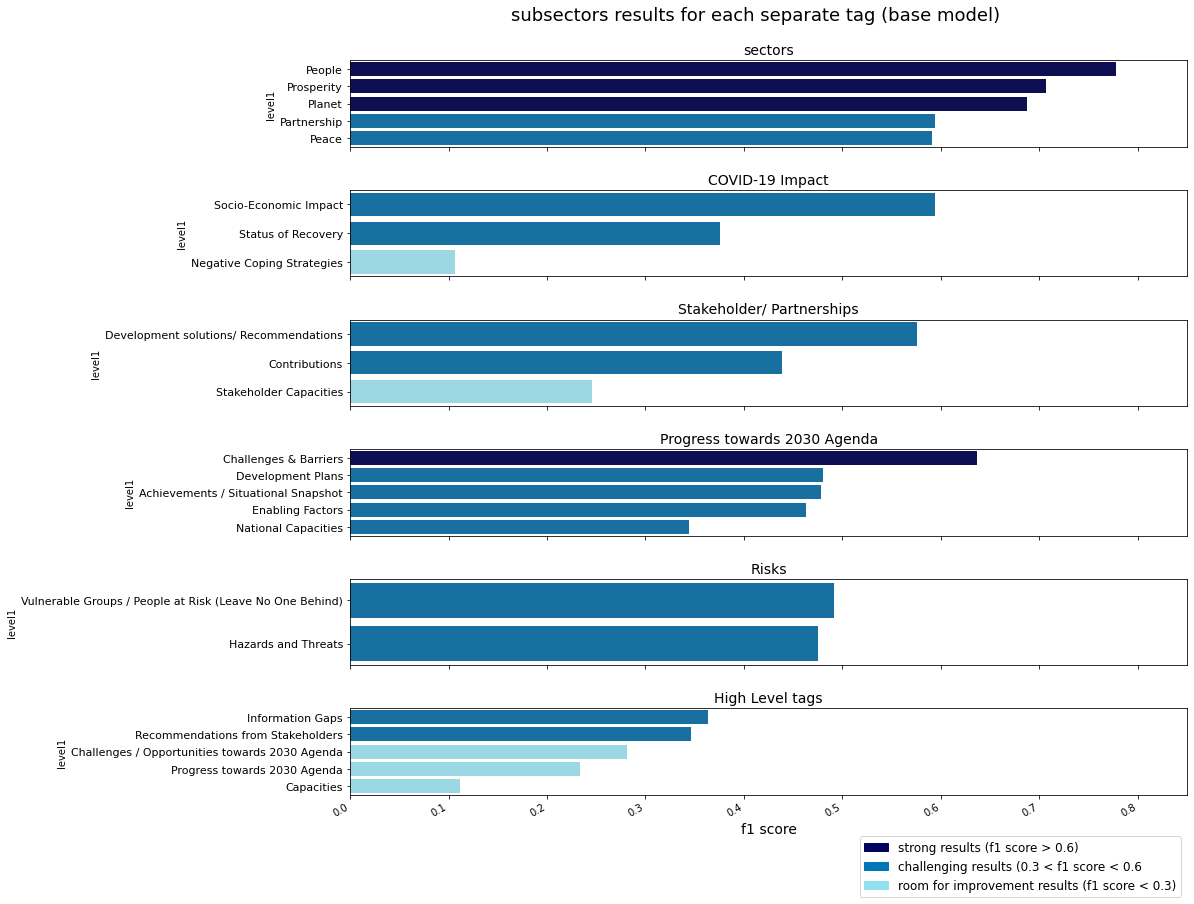

In [15]:
vizu_df = postprocessed_results_df[
    postprocessed_results_df.apply(lambda x: 'mean' not in x['level0'] and 'mean' not in x['level1'], axis=1)]

#vizu_df.drop(vizu_df.tail(1).index,inplace=True)
vizu_df.sort_values(by='binary_f1_score', inplace=True, ascending=False)

#vizu_df = vizu_df[['binary_f1_score']]#.rename(columns={'1_f1_score': 'tag reliability'})
#vizu_df['tag_name'] = vizu_df.index


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = values 
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

custom_palette = {}
for v in list(vizu_df['level1']):
    q = vizu_df[vizu_df['level1']==v]['binary_f1_score'].values[0]
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_level0 = [
    "sectors",
    "COVID-19 Impact",
    "Stakeholder/ Partnerships",
    "Progress towards 2030 Agenda",
    "Risks",
    "High Level tags",
]
n_treated_sectors = len(ordered_level0)
fig, axes = plt.subplots(n_treated_sectors, 1, sharex=True, figsize=(15,15), facecolor='white')


for i in range (n_treated_sectors):
    level0_tmp = ordered_level0[i]
    one_level_results_df = vizu_df[vizu_df.level0==level0_tmp]
    
    y = one_level_results_df['binary_f1_score']

    axes[i].set_title(f'{level0_tmp}', fontsize=14)
    plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].set_xlim([0, 0.85])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=one_level_results_df['level1'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]
fig.suptitle('subsectors results for each separate tag (base model)', fontsize=18, y=0.93)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0.1))


plt.savefig('CCA_vizu/deployable_model_vizu.png', bbox_inches="tight", dpi=200)
